## Feature set 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [3]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 32, 8, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [4]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 32, 8))
    return X_fold_basic_nn,Y_fold_basic_nn

In [13]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 256))
    return X_fold_log_reg,Y_fold_log_reg

In [14]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [15]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [16]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

##### shapes of data

In [17]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 32, 8, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 32, 8, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 32, 8, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 32, 8, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 32, 8, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 32, 8, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 32, 8, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 32, 8, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 32, 8, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 32, 8, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 32, 8)
Y_data 1 = (873, 1)
X_data 2 = (888, 32, 8)
Y_data 2 = (888, 1)
X_data 3 = (925, 32, 8)
Y_data 3 = (925, 1)
X_data 4 = (990, 32, 8)
Y_data 4 = (990, 1)
X_data 5 = (936, 32, 8)
Y_data 5 = (936, 1)
X_data 6 = (823, 32, 8)
Y_data 6 = (823, 1)
X_data 7 = (838, 32, 8)
Y_data 7 = (838, 1)
X_data 8 = (806, 32, 8)
Y_data 8 = (806, 1)
X_data 9 = (816, 32, 8)
Y_data 9 = (816, 1)
X_data 10 = (837, 32, 8)
Y_data 10 = (837, 1)


# Defining Functions
## Simple nn function

In [56]:

def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [57]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [58]:
def Model_run_nn_es_NO_EARLY_STOPPING(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph function

In [59]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(val_loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

### Table function

In [60]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [61]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 3")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion matrix function

In [62]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [63]:
def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [64]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

## Model 1

In [27]:
model=Sequential()
model.add(Flatten(input_shape=[32, 8]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [28]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array_1=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array_1, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8) (7859, 1) (873, 32, 8) (873, 1)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.27912965416908264
Time to train Fold 1 : 43.0006 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8) (7844, 1) (888, 32, 8) (888, 1)
Accuracy of Fold 2 is 0.21332992613315582
Time to train Fold 2 : 45.9666 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8) (7807, 1) (925, 32, 8) (925, 1)
Accuracy of Fold 3 is 0.23795312643051147
Time to train Fold 3 : 45.7469 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8) (7742, 1) (990, 32, 8) (990, 1)
Accuracy of Fold 4 is 0.19165848195552826
Time to train Fold 4 : 43.9468 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8) (7796, 1) (936, 32, 8) (936, 1)
Accuracy of Fold 5 is 0.19354283809661865
Time to train Fold 5 : 43.7109 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8) (7909, 1) (823, 32, 8) (823, 1)
Accuracy of Fold 6 is 0.2149095982313156
Time to train Fold 6 : 42.8133 seconds.

Fold #7
- - - - - - - - - - - - -

In [29]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.13175377718374645, 0.2282164319186391, 0.1981672394043528, 0.1981672394043528
2, 0.14274959529307177, 0.19871682613930675, 0.20945945945945946, 0.20945945945945946
3, 0.16246041453126298, 0.2739426343114868, 0.20540540540540542, 0.20540540540540542
4, 0.18236410115873108, 0.28028390760098076, 0.23030303030303031, 0.23030303030303031
5, 0.13206749867376516, 0.48195832782936854, 0.18162393162393162, 0.18162393162393162
6, 0.18591557516985, 0.4456137051823565, 0.2077764277035237, 0.2077764277035237
7, 0.05420174849695046, 0.3462817179021361, 0.11217183770883055, 0.11217183770883055
8, 0.16099805255869587, 0.21899390931648996, 0.20967741935483872, 0.20967741935483872
9, 0.1797727011112522, 0.4281186055542703, 0.22426470588235295, 0.22426470588235295
10, 0.20840933370566206, 0.325442964234538, 0.2532855436081243, 0.2532855436081243


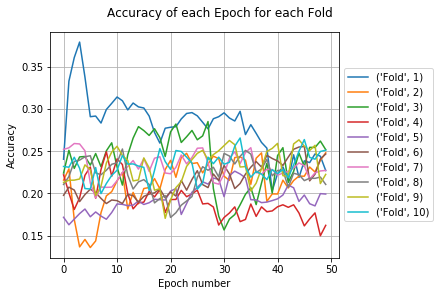

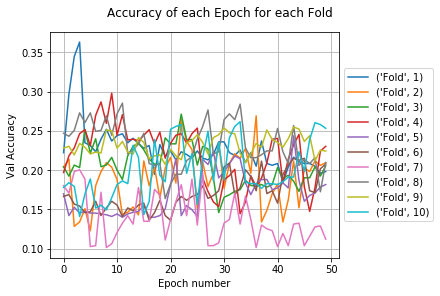

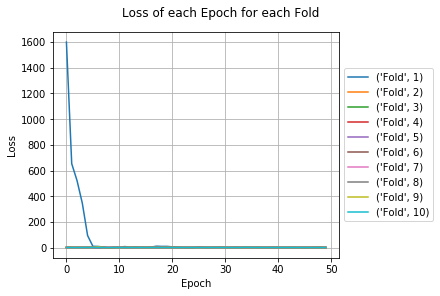

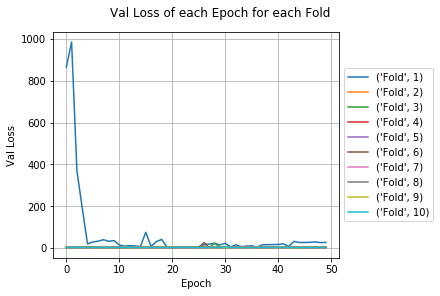

In [30]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array_1)

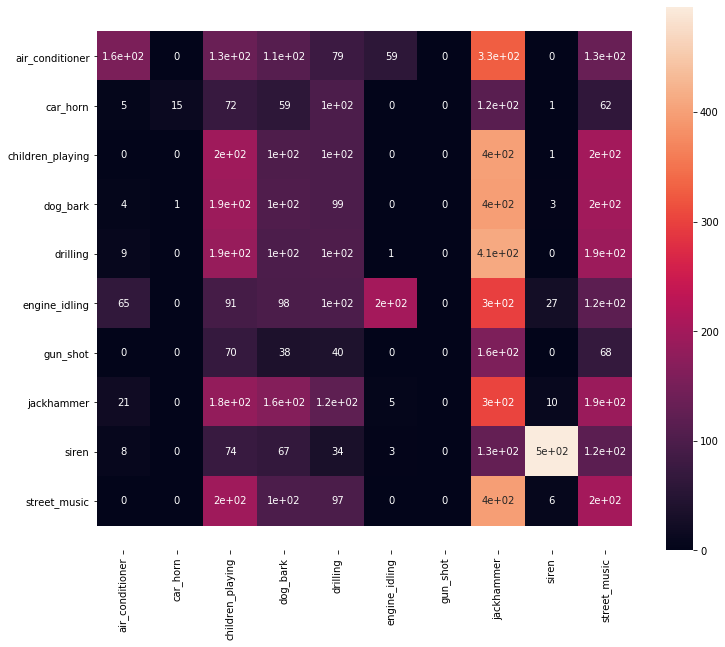

In [31]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [32]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.279130     43.0006
1    2  0.213330     45.9666
2    3  0.237953     45.7469
3    4  0.191658     43.9468
4    5  0.193543     43.7109
5    6  0.214910     42.8133
6    7  0.231751     49.0585
7    8  0.221312     40.9729
8    9  0.231326     42.1829
9   10  0.232469     39.7916

    Average Accuracy  Total Time
0          0.224738     437.191


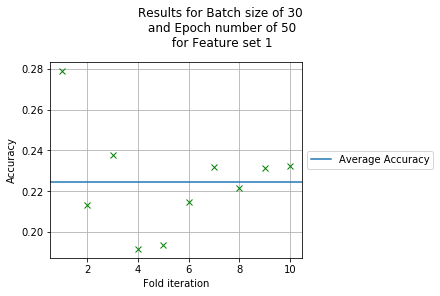

In [33]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

### Model 1 no cross validation

In [34]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 1s - loss: 2.0649 - accuracy: 0.18 - ETA: 0s - loss: 1.9181 - accuracy: 0.27 - ETA: 0s - loss: 1.9417 - accuracy: 0.26 - ETA: 0s - loss: 1.9334 - accuracy: 0.26 - ETA: 0s - loss: 1.9478 - accuracy: 0.25 - ETA: 0s - loss: 1.9648 - accuracy: 0.24 - ETA: 0s - loss: 1.9809 - accuracy: 0.24 - ETA: 0s - loss: 1.9945 - accuracy: 0.23 - ETA: 0s - loss: 1.9871 - accuracy: 0.23 - ETA: 0s - loss: 1.9861 - accuracy: 0.23 - ETA: 0s - loss: 1.9882 - accuracy: 0.23 - ETA: 0s - loss: 1.9902 - accuracy: 0.23 - ETA: 0s - loss: 1.9879 - accuracy: 0.23 - ETA: 0s - loss: 1.9859 - accuracy: 0.23 - ETA: 0s - loss: 1.9849 - accuracy: 0.23 - ETA: 0s - loss: 1.9836 - accuracy: 0.23 - ETA: 0s - loss: 1.9821 - accuracy: 0.23 - ETA: 0s - loss: 1.9794 - accuracy: 0.23 - ETA: 0s - loss: 1.9810 - accuracy: 0.23 - ETA: 0s - loss: 1.9805 - accuracy: 0.23 - ETA: 0s - loss: 1.9798 - accuracy: 0.23 - ETA: 0s - loss:

## Model 2

In [35]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,8,1)))
model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)
Accuracy of Fold 1 is 0.8330894112586975
Time to train Fold 1 : 92.765 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.8927701115608215
Time to train Fold 2 : 70.0996 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.9088600873947144
Time to train Fold 3 : 66.87 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.9144392013549805
Time to train Fold 4 : 66.2202 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.9207889437675476
Time to train Fold 5 : 65.9243 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (823, 

In [37]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.5508621049254887, 0.550766489402088, 0.5647193585337915, 0.5647193585337915
1, 0.7805825199510871, 0.789211655361219, 0.7804054054054054, 0.7804054054054054
2, 0.70283504913805, 0.7375233318844968, 0.7016216216216217, 0.7016216216216217
3, 0.7520413640953444, 0.7697986361366107, 0.7525252525252525, 0.7525252525252525
4, 0.8071563832585728, 0.8263880806099183, 0.811965811965812, 0.811965811965812
5, 0.7949972257804815, 0.8090350440187869, 0.7970838396111786, 0.7970838396111786
6, 0.8805435315161139, 0.8838899872527316, 0.8806682577565632, 0.8806682577565632
7, 0.859747151569052, 0.8659461461650217, 0.8610421836228288, 0.8610421836228288
8, 0.8908938976735389, 0.8970994075989719, 0.8909313725490197, 0.8909313725490197
9, 0.8842333412143735, 0.8912978522142001, 0.8841099163679809, 0.8841099163679809


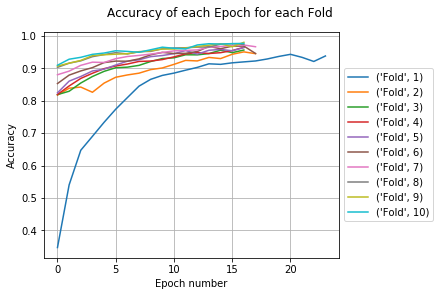

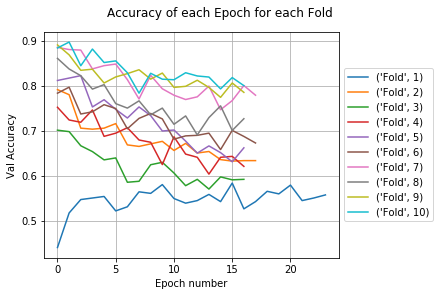

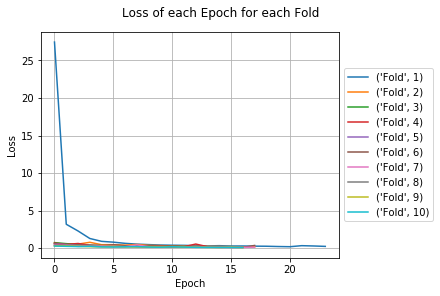

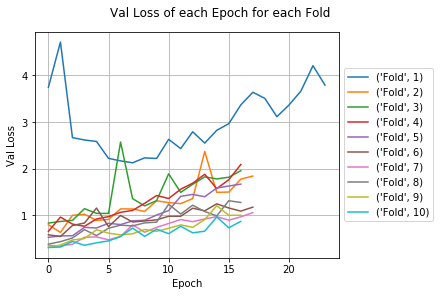

In [38]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2)

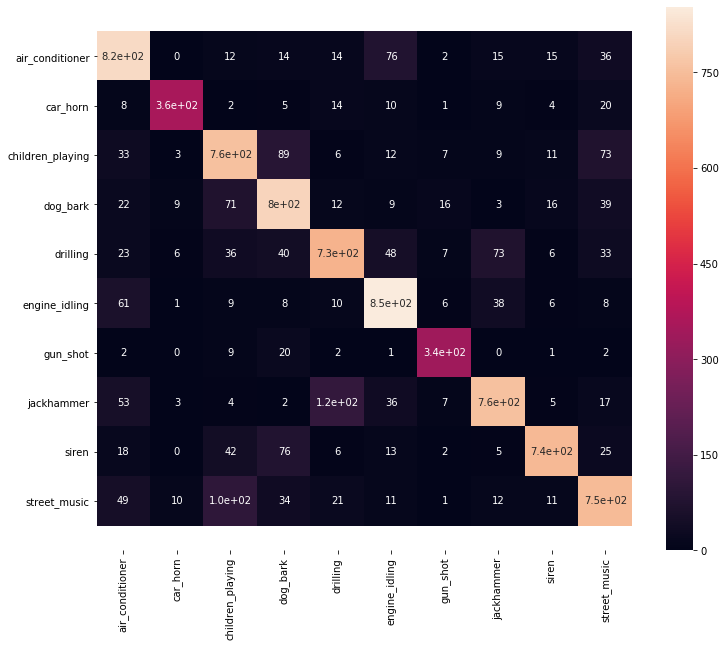

In [39]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [40]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.833089     92.7650
1    2  0.892770     70.0996
2    3  0.908860     66.8700
3    4  0.914439     66.2202
4    5  0.920789     65.9243
5    6  0.930951     65.8659
6    7  0.939884     65.8651
7    8  0.950201     65.8085
8    9  0.950554     65.0697
9   10  0.954841     66.2469

    Average Accuracy  Total Time
0          0.919638    690.7352


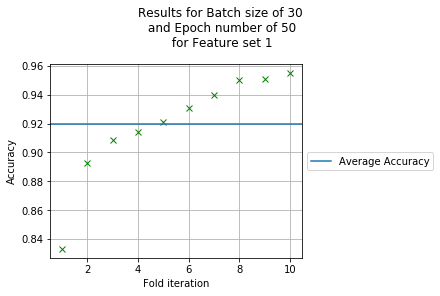

In [41]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 no cross validation

In [42]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 32, 8,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 4s - loss: 0.3378 - accuracy: 0.87 - ETA: 4s - loss: 0.1842 - accuracy: 0.93 - ETA: 4s - loss: 0.1849 - accuracy: 0.95 - ETA: 4s - loss: 0.1907 - accuracy: 0.95 - ETA: 4s - loss: 0.1904 - accuracy: 0.94 - ETA: 4s - loss: 0.1937 - accuracy: 0.94 - ETA: 4s - loss: 0.1908 - accuracy: 0.94 - ETA: 4s - loss: 0.1837 - accuracy: 0.94 - ETA: 4s - loss: 0.1870 - accuracy: 0.94 - ETA: 4s - loss: 0.1761 - accuracy: 0.94 - ETA: 4s - loss: 0.1814 - accuracy: 0.94 - ETA: 3s - loss: 0.1865 - accuracy: 0.94 - ETA: 3s - loss: 0.1907 - accuracy: 0.93 - ETA: 3s - loss: 0.1879 - accuracy: 0.93 - ETA: 3s - loss: 0.1862 - accuracy: 0.93 - ETA: 3s - loss: 0.1914 - accuracy: 0.93 - ETA: 3s - loss: 0.1977 - accuracy: 0.93 - ETA: 3s - loss: 0.2086 - accuracy: 0.93 - ETA: 3s - loss: 0.2128 - accuracy: 0.92 - ETA: 3s - loss: 0.2135 - accuracy: 0.92 - ETA: 3s - loss: 0.2129 - accuracy: 0.92 - ETA: 3s - loss:

## Model 3

In [43]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(32,8,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [44]:
Accuracy_array_3=[]
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.1133073940873146
Time to train Fold 1 : 146.2834 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.11120912432670593
Time to train Fold 2 : 185.5019 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.11237066239118576
Time to train Fold 3 : 94.2349 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.11102500557899475
Time to train Fold 4 : 91.141 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.11171720921993256
Time to train Fold 5 : 95.5184 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (823, 32, 8, 1) (823, 10)
Accuracy of Fold 6 is 0.11721526086330414
Time to train Fold 6 : 89.3872 se

In [45]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.07529260100568855, 0.1235376188227119, 0.14776632302405499, 0.14776632302405499
2, 0.02279607542765438, 0.012681600519438356, 0.11261261261261261, 0.11261261261261261
3, 0.02109426499670402, 0.01168736303871439, 0.10810810810810811, 0.10810810810810811
4, 0.030114157939648584, 0.11834606224850126, 0.10707070707070707, 0.10707070707070707
5, 0.026920350274658115, 0.12576721539744048, 0.11004273504273504, 0.11004273504273504
6, 0.042496247888899344, 0.14490267552950706, 0.13001215066828675, 0.13001215066828675
7, 0.015082278844597171, 0.008225061374678887, 0.09069212410501193, 0.09069212410501193
8, 0.017077798861480076, 0.009365244536940686, 0.0967741935483871, 0.0967741935483871
9, 0.03225286574389019, 0.11924170902929072, 0.10784313725490197, 0.10784313725490197
10, 0.023602899653101916, 0.013155021132822036, 0.11469534050179211, 0.11469534050179211


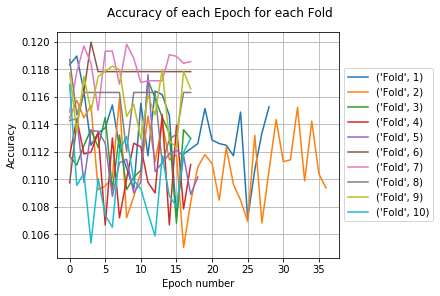

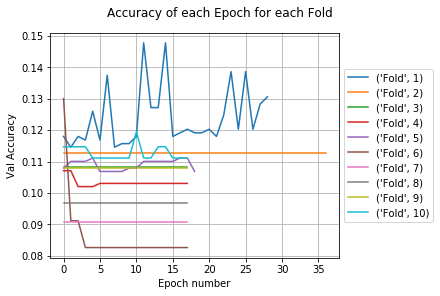

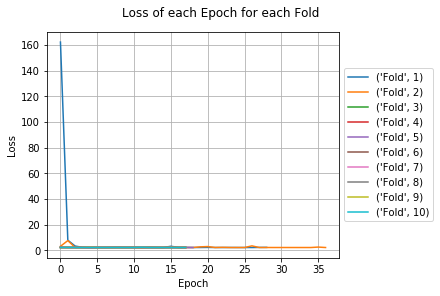

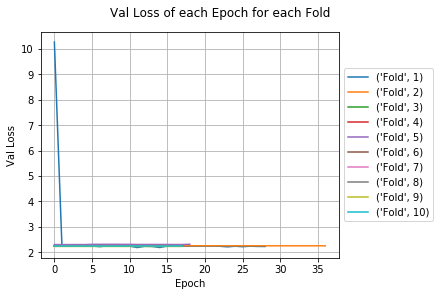

In [46]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3)

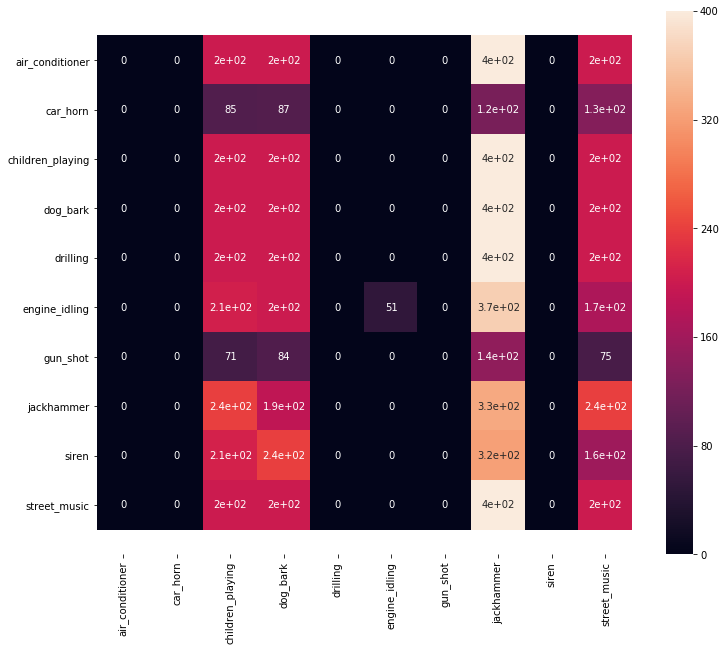

In [47]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [48]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.113307    146.2834
1    2  0.111209    185.5019
2    3  0.112371     94.2349
3    4  0.111025     91.1410
4    5  0.111717     95.5184
5    6  0.117215     89.3872
6    7  0.117987     80.5470
7    8  0.115485     84.3228
8    9  0.115919     90.5317
9   10  0.109873     91.6244

    Average Accuracy  Total Time
0          0.113611   1049.0927


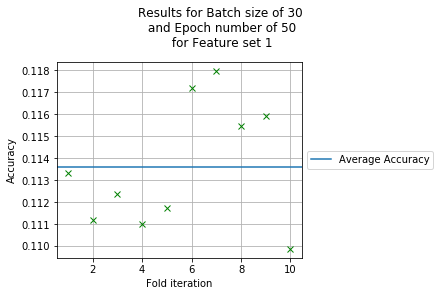

In [49]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

### Model 3 no cross validation

In [50]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 5s - loss: 2.1963 - accuracy: 0.12 - ETA: 5s - loss: 2.2434 - accuracy: 0.16 - ETA: 5s - loss: 2.2479 - accuracy: 0.13 - ETA: 5s - loss: 2.2473 - accuracy: 0.12 - ETA: 5s - loss: 2.2494 - accuracy: 0.12 - ETA: 5s - loss: 2.2569 - accuracy: 0.11 - ETA: 5s - loss: 2.2592 - accuracy: 0.11 - ETA: 5s - loss: 2.2566 - accuracy: 0.11 - ETA: 4s - loss: 2.2550 - accuracy: 0.11 - ETA: 4s - loss: 2.2580 - accuracy: 0.11 - ETA: 4s - loss: 2.2582 - accuracy: 0.11 - ETA: 4s - loss: 2.2573 - accuracy: 0.12 - ETA: 4s - loss: 2.2548 - accuracy: 0.11 - ETA: 4s - loss: 2.2545 - accuracy: 0.11 - ETA: 4s - loss: 2.2549 - accuracy: 0.11 - ETA: 4s - loss: 2.2536 - accuracy: 0.11 - ETA: 4s - loss: 2.2532 - accuracy: 0.11 - ETA: 4s - loss: 2.2546 - accuracy: 0.11 - ETA: 4s - loss: 2.2550 - accuracy: 0.11 - ETA: 4s - loss: 2.2537 - accuracy: 0.11 - ETA: 4s - loss: 2.2538 - accuracy: 0.11 - ETA: 4s - loss:

## Model 4

In [54]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(32,8,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [65]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es_NO_EARLY_STOPPING(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)
Accuracy of Fold 1 is 0.8776943683624268
Time to train Fold 1 : 81.4863 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.9002371430397034
Time to train Fold 2 : 71.2016 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.9233046770095825
Time to train Fold 3 : 75.0801 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.9334203600883484
Time to train Fold 4 : 70.4796 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.9431606531143188
Time to train Fold 5 : 73.3283 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (82

In [66]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.4994860886196555, 0.5401524432995266, 0.5120274914089347, 0.5120274914089347
2, 0.6826301941995441, 0.7202731080420912, 0.6903153153153153, 0.6903153153153153
3, 0.7818415611489724, 0.7984113303218687, 0.7794594594594595, 0.7794594594594595
4, 0.7874322825767344, 0.8096010010677993, 0.7929292929292929, 0.7929292929292929
5, 0.8567249422360257, 0.8882738591811724, 0.8504273504273504, 0.8504273504273504
6, 0.7788835051926639, 0.8139760886835321, 0.7776427703523694, 0.7776427703523694
7, 0.866602537844813, 0.8868438384993953, 0.8651551312649165, 0.8651551312649165
8, 0.8596695840822632, 0.8727854559105844, 0.8598014888337469, 0.8598014888337469
9, 0.8863678092185046, 0.8972270775176331, 0.8860294117647058, 0.8860294117647058
10, 0.9193053512110527, 0.9257840718232876, 0.9199522102747909, 0.9199522102747909


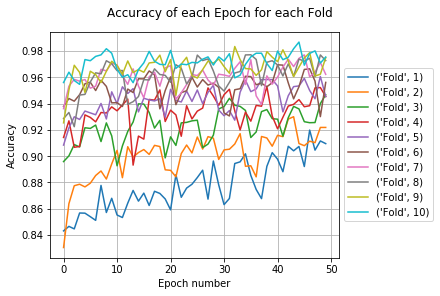

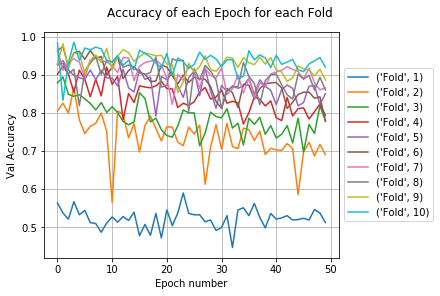

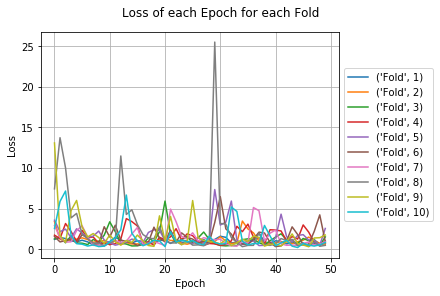

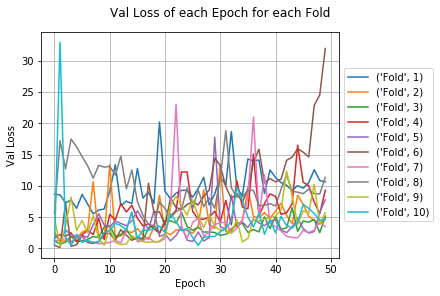

In [67]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4)

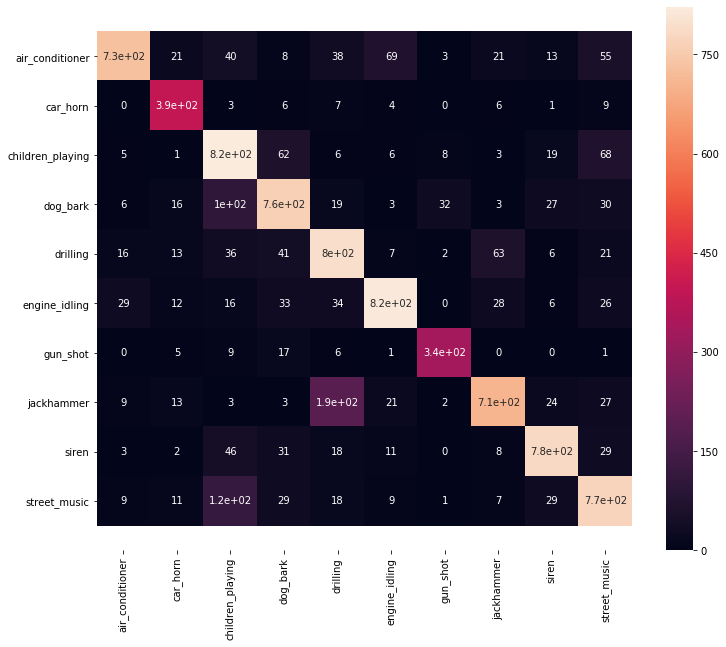

In [68]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [69]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.877694     81.4863
1    2  0.900237     71.2016
2    3  0.923305     75.0801
3    4  0.933420     70.4796
4    5  0.943161     73.3283
5    6  0.951880     71.9422
6    7  0.960241     73.3044
7    8  0.961348     73.9439
8    9  0.966703     85.2459
9   10  0.971357     75.7831

    Average Accuracy  Total Time
0          0.938934    751.7954


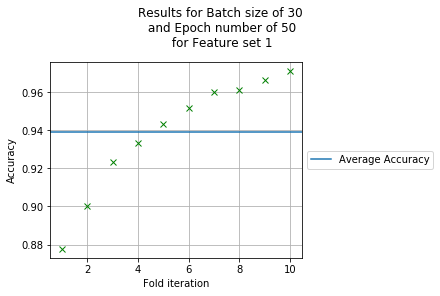

In [70]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [84]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 5s - loss: 0.5041 - accuracy: 0.96 - ETA: 1s - loss: 0.3353 - accuracy: 0.97 - ETA: 1s - loss: 0.4092 - accuracy: 0.97 - ETA: 1s - loss: 0.2804 - accuracy: 0.98 - ETA: 1s - loss: 0.4320 - accuracy: 0.98 - ETA: 1s - loss: 0.3801 - accuracy: 0.98 - ETA: 1s - loss: 0.3562 - accuracy: 0.98 - ETA: 1s - loss: 0.3577 - accuracy: 0.98 - ETA: 1s - loss: 0.3929 - accuracy: 0.98 - ETA: 1s - loss: 0.3857 - accuracy: 0.98 - ETA: 1s - loss: 0.4135 - accuracy: 0.98 - ETA: 0s - loss: 0.3801 - accuracy: 0.98 - ETA: 0s - loss: 0.3528 - accuracy: 0.98 - ETA: 0s - loss: 0.3802 - accuracy: 0.98 - ETA: 0s - loss: 0.3983 - accuracy: 0.98 - ETA: 0s - loss: 0.3975 - accuracy: 0.98 - ETA: 0s - loss: 0.4071 - accuracy: 0.98 - ETA: 0s - loss: 0.4211 - accuracy: 0.98 - ETA: 0s - loss: 0.4730 - accuracy: 0.97 - ETA: 0s - loss: 0.4954 - accuracy: 0.97 - ETA: 0s - loss: 0.5376 - accuracy: 0.97 - ETA: 0s - loss:

## Model from Github

In [72]:
# Model from GitHub

#adding layers and forming the model

#forming model
model_5=Sequential()

model_5.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(32,8,1)))
model_5.add(MaxPooling2D(padding="same"))

model_5.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model_5.add(MaxPooling2D(padding="same"))
model_5.add(Dropout(0.3))

model_5.add(Flatten())

model_5.add(Dense(256,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(512,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(10,activation="softmax"))

#compiling
Model_5=model_5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [73]:
Accuracy_array_5=[]
accuracy_total_5=0
end_array_5=[]

Epoch_array_accuracy_5=[]
Loss_array_5=[]
Fold_accuracy_5=[]

Val_accuracy_array_5=[]
Val_Loss_array_5=[]

Avg_Accuracy_5=[]
Time_5=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_5=Model_run_nn_es_NO_EARLY_STOPPING(Model_5,model_5,X_folds_10,Y_folds_10,Accuracy_array_5,
                     accuracy_total_5,end_array_5,Epoch_array_accuracy_5,Loss_array_5,
                     Fold_accuracy_5,Val_accuracy_array_5,Val_Loss_array_5, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_5=Model_5[0]
Time_5=Model_5[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 32, 8, 1) (7859, 10) (873, 32, 8, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.11269881576299667
Time to train Fold 1 : 354.5515 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 32, 8, 1) (7844, 10) (888, 32, 8, 1) (888, 10)
Accuracy of Fold 2 is 0.11179756373167038
Time to train Fold 2 : 1376.8111 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 32, 8, 1) (7807, 10) (925, 32, 8, 1) (925, 10)
Accuracy of Fold 3 is 0.11126425862312317
Time to train Fold 3 : 491.8424 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 32, 8, 1) (7742, 10) (990, 32, 8, 1) (990, 10)
Accuracy of Fold 4 is 0.11105141043663025
Time to train Fold 4 : 446.1304 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 32, 8, 1) (7796, 10) (936, 32, 8, 1) (936, 10)
Accuracy of Fold 5 is 0.11075937002897263
Time to train Fold 5 : 502.2208 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 32, 8, 1) (7909, 10) (823, 32, 8, 1) (823, 10)
Accuracy of Fold 6 is 0.11748640239238739
Time to train Fold 6 : 508.

In [74]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.021788856616982114, 0.0120924410434454, 0.10996563573883161, 0.10996563573883161
2, 0.02279607542765438, 0.012681600519438356, 0.11261261261261261, 0.11261261261261261
3, 0.02109426499670402, 0.01168736303871439, 0.10810810810810811, 0.10810810810810811
4, 0.01853396348809193, 0.010203040506070809, 0.10101010101010101, 0.10101010101010101
5, 0.020625020625020623, 0.011414274234787055, 0.10683760683760683, 0.10683760683760683
6, 0.012611602729059193, 0.006826815329035078, 0.08262454434993925, 0.08262454434993925
7, 0.015082278844597171, 0.008225061374678887, 0.09069212410501193, 0.09069212410501193
8, 0.017077798861480076, 0.009365244536940686, 0.0967741935483871, 0.0967741935483871
9, 0.018352329796060964, 0.010098279507881584, 0.10049019607843138, 0.10049019607843138
10, 0.02222222222222222, 0.012345679012345678, 0.1111111111111111, 0.1111111111111111


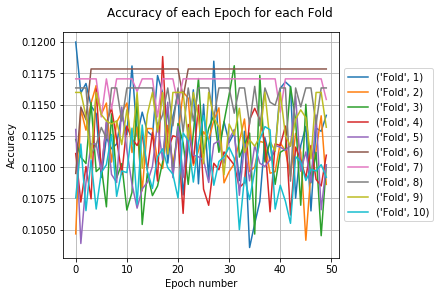

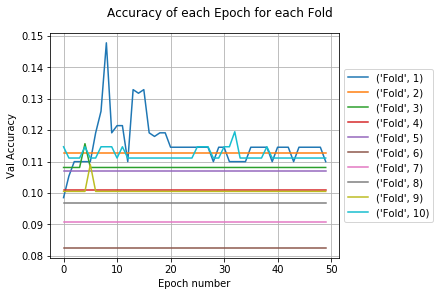

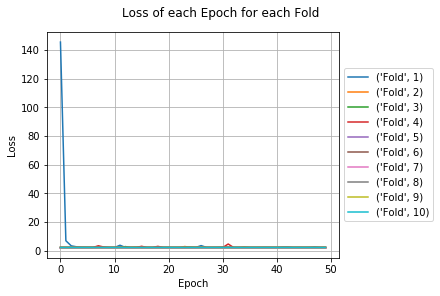

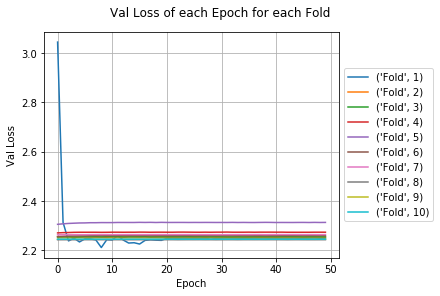

In [75]:
Graph_Epochs_model_5=Graph_func(Epoch_number,Epoch_array_accuracy_5,Val_accuracy_array_5,Loss_array_5,Val_Loss_array_5) 

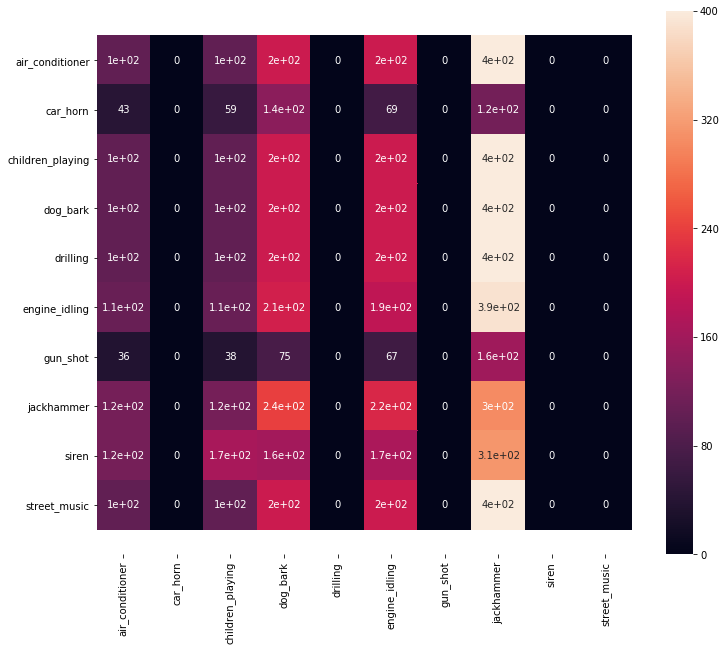

In [76]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [77]:
Table_model_5=table_maker(Fold_accuracy_5,end_array_5,Avg_Accuracy_5,Time_5)

  Fold  Accuracy  Time Taken
0    1  0.112699    354.5515
1    2  0.111798   1376.8111
2    3  0.111264    491.8424
3    4  0.111051    446.1304
4    5  0.110759    502.2208
5    6  0.117486    508.7421
6    7  0.116734    463.4432
7    8  0.115150    408.2076
8    9  0.113605    415.0115
9   10  0.109875    450.6264

    Average Accuracy  Total Time
0          0.113042    5417.587


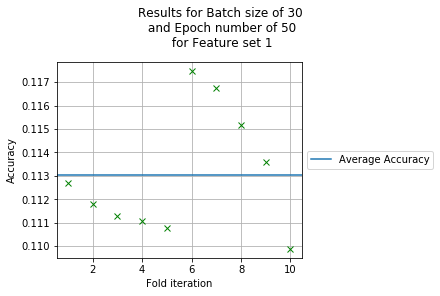

In [78]:
Graph_Avg_model_5=Graph_Avg_maker(Fold_accuracy_5,Avg_Accuracy_5)

### Github model with no cross validation

In [79]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_5_history = model_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_5_no_cross=model_5.evaluate(X_test, y_test)
accuracy_model_5_no_cross = score_model_5_no_cross[1]
print(f"\nAccuracy of model 5 with no cross validation: {round(accuracy_model_5_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 6s - loss: 2.2838 - accuracy: 0.15 - ETA: 6s - loss: 2.2650 - accuracy: 0.11 - ETA: 7s - loss: 2.2841 - accuracy: 0.10 - ETA: 7s - loss: 2.2684 - accuracy: 0.10 - ETA: 7s - loss: 2.2760 - accuracy: 0.11 - ETA: 8s - loss: 2.2641 - accuracy: 0.13 - ETA: 8s - loss: 2.2676 - accuracy: 0.13 - ETA: 8s - loss: 2.2629 - accuracy: 0.13 - ETA: 9s - loss: 2.2631 - accuracy: 0.13 - ETA: 9s - loss: 2.2647 - accuracy: 0.14 - ETA: 9s - loss: 2.2630 - accuracy: 0.13 - ETA: 9s - loss: 2.2627 - accuracy: 0.13 - ETA: 9s - loss: 2.2600 - accuracy: 0.13 - ETA: 9s - loss: 2.2595 - accuracy: 0.13 - ETA: 9s - loss: 2.2603 - accuracy: 0.13 - ETA: 9s - loss: 2.2591 - accuracy: 0.13 - ETA: 10s - loss: 2.2595 - accuracy: 0.127 - ETA: 10s - loss: 2.2596 - accuracy: 0.127 - ETA: 10s - loss: 2.2573 - accuracy: 0.128 - ETA: 10s - loss: 2.2586 - accuracy: 0.126 - ETA: 10s - loss: 2.2588 - accuracy: 0.125 - ETA: 

### Model comparisson

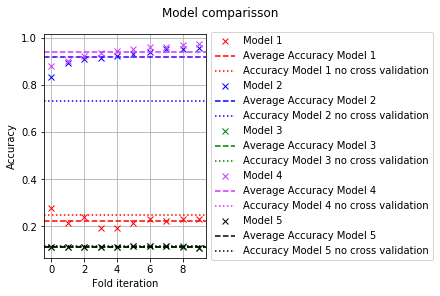

In [82]:


%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Fold_accuracy_4,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Fold_accuracy_5,"kx",label="Model 5")
ax1.axhline(y=Avg_Accuracy_5,label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.44


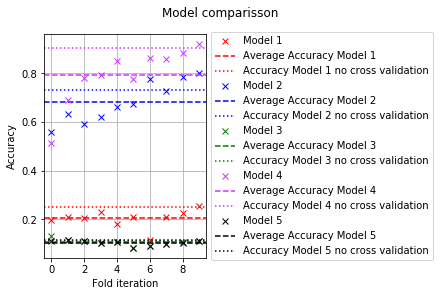

In [85]:
Val_accuracy_array_fix = [Val_accuracy_array[i][-1] for i in range(10)]
Val_accuracy_array_2_fix = [Val_accuracy_array_2[i][-1] for i in range(10)]
Val_accuracy_array_3_fix = [Val_accuracy_array_3[i][-1] for i in range(10)]
Val_accuracy_array_4_fix = [Val_accuracy_array_4[i][-1] for i in range(10)]
Val_accuracy_array_5_fix = [Val_accuracy_array_5[i][-1] for i in range(10)]

 

%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Val_accuracy_array_fix,"rx",label="Model 1")
ax1.axhline(y=np.average(Val_accuracy_array_fix),label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Val_accuracy_array_2_fix,"bx",label="Model 2")
ax1.axhline(y=np.average(Val_accuracy_array_2_fix),label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Val_accuracy_array_3_fix,"gx",label="Model 3")
ax1.axhline(y=np.average(Val_accuracy_array_3_fix),label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Val_accuracy_array_4_fix,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=np.average(Val_accuracy_array_4_fix),label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Val_accuracy_array_5_fix,"kx",label="Model 5")
ax1.axhline(y=np.average(Val_accuracy_array_5_fix),label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))